<a href="https://colab.research.google.com/github/dhillonarman/seeds-clustering-analysis/blob/main/102216076_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#  Load Seeds Dataset directly from UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
col_names = ['area','perimeter','compactness','length','width','asymmetry','groove','class']
df = pd.read_csv(url, sep='\s+', header=None, names=col_names)


X = df.drop('class', axis=1)

In [10]:
# Preprocessing Techniques
def preprocess(X, method):
    if method == "none":
        return X.values
    elif method == "normalize":
        return StandardScaler().fit_transform(X)
    elif method == "transform":
        return PowerTransformer().fit_transform(X)
    elif method == "pca":
        # apply PCA on standardized data
        return PCA(n_components=5).fit_transform(StandardScaler().fit_transform(X))
    elif method == "t+n":
        # Power transform then standardize
        return StandardScaler().fit_transform(PowerTransformer().fit_transform(X))
    elif method == "t+n+pca":
        # Power transform → standardize → PCA
        return PCA(n_components=5).fit_transform(
            StandardScaler().fit_transform(
                PowerTransformer().fit_transform(X)
            )
        )
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

In [11]:
# Clustering Methods
clustering_algos = {
    "KMeans": lambda c: KMeans(n_clusters=c, n_init=10, random_state=42),
    "Hierarchical": lambda c: AgglomerativeClustering(n_clusters=c),
    "MeanShift": lambda _: MeanShift()
}

#  Parameters
preprocessing_methods = ["none", "normalize", "transform", "pca", "t+n", "t+n+pca"]
clusters = [3, 4, 5]

# Results
results = []
for method in preprocessing_methods:
    X_proc = preprocess(X, method)
    for algo_name, algo_fn in clustering_algos.items():
        for c in clusters:

            if algo_name == "MeanShift" and method in ["transform","t+n","t+n+pca"]:

                continue
            try:
                model = algo_fn(c)
                labels = model.fit_predict(X_proc)
                sil = silhouette_score(X_proc, labels)
                ch = calinski_harabasz_score(X_proc, labels)
                db = davies_bouldin_score(X_proc, labels)
                results.append([algo_name, method, c, sil, ch, db])
            except Exception as e:
                results.append([algo_name, method, c, np.nan, np.nan, np.nan])

# DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Algorithm","Preprocessing","Clusters","Silhouette","Calinski-Harabasz","Davies-Bouldin"]
).sort_values(["Algorithm","Preprocessing","Clusters"]).reset_index(drop=True)

# Save to CSV
results_df.to_csv("seeds_clustering_results.csv", index=False)
print("Results saved to seeds_clustering_results.csv")

Results saved to seeds_clustering_results.csv


       Algorithm Preprocessing  Clusters  Silhouette  Calinski-Harabasz  \
0   Hierarchical          none         3    0.449361         352.835503   
1   Hierarchical          none         4    0.392234         292.936494   
2   Hierarchical          none         5    0.326961         265.604191   
3   Hierarchical     normalize         3    0.392634         238.361196   
4   Hierarchical     normalize         4    0.300576         183.200413   
5   Hierarchical     normalize         5    0.274639         157.156828   
6   Hierarchical           pca         3    0.397118         242.178683   
7   Hierarchical           pca         4    0.303856         190.012489   
8   Hierarchical           pca         5    0.251928         164.370939   
9   Hierarchical           t+n         3    0.391914         225.101669   
10  Hierarchical           t+n         4    0.359306         174.634144   
11  Hierarchical           t+n         5    0.283774         148.565940   
12  Hierarchical       t+

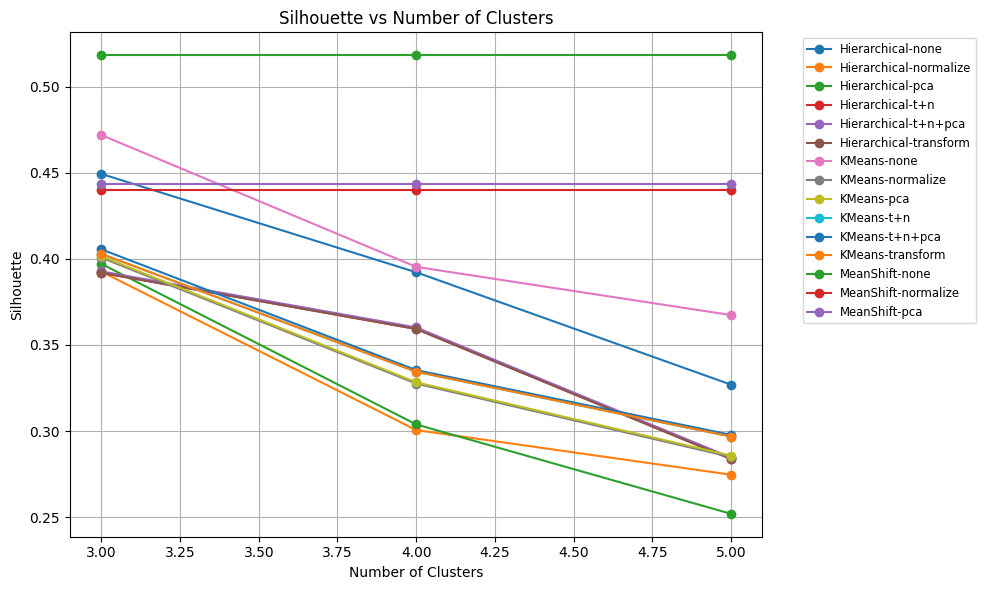

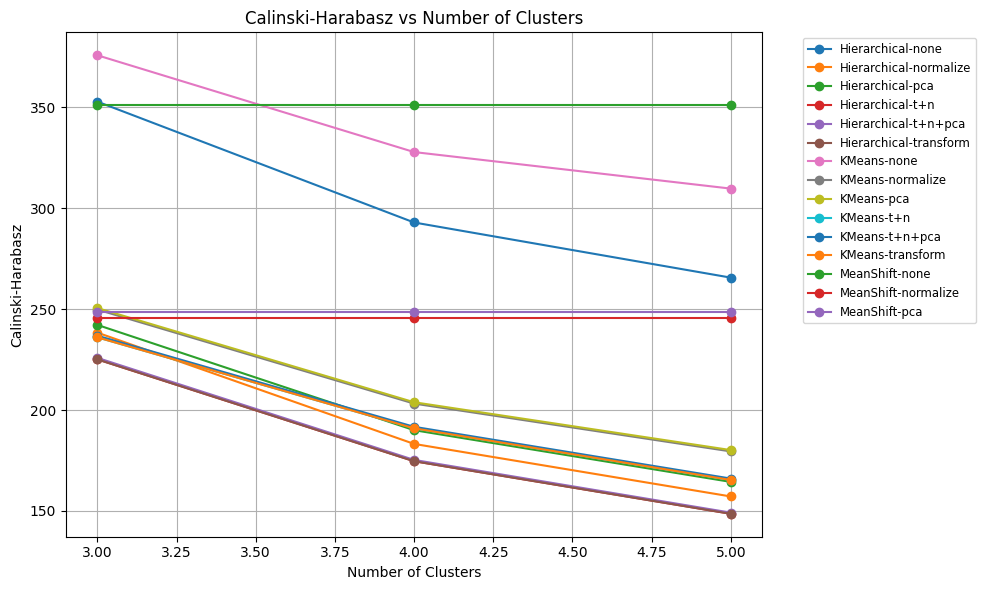

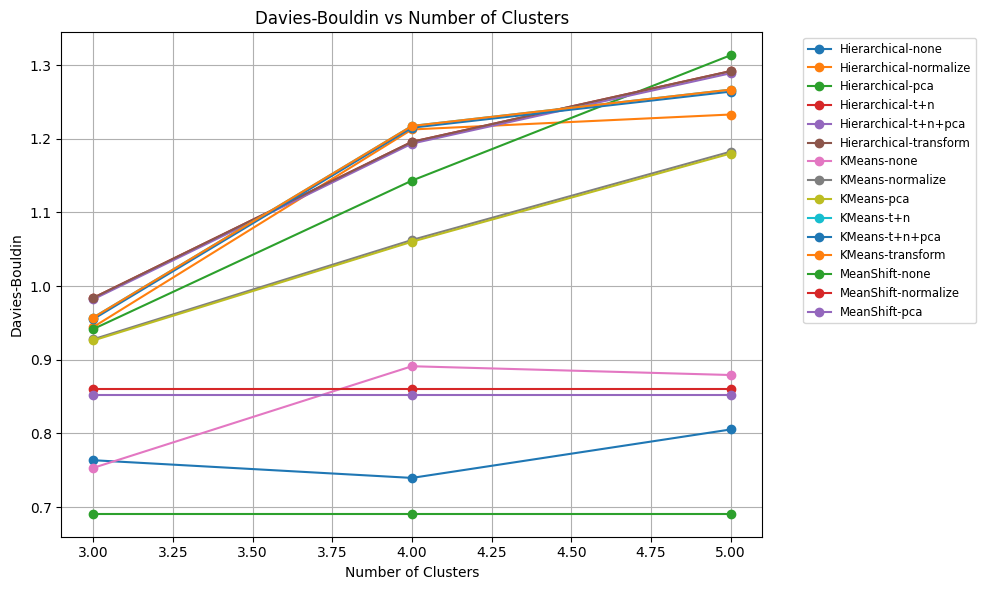

In [12]:
# Plotting function
def plot_metrics(df, metric, fname):
    plt.figure(figsize=(10,6))
    for algo in df["Algorithm"].unique():
        sub = df[df["Algorithm"] == algo]
        for method in sub["Preprocessing"].unique():
            ss = sub[sub["Preprocessing"] == method]
            plt.plot(
                ss["Clusters"], ss[metric],
                marker='o', label=f"{algo}-{method}"
            )
    plt.title(f"{metric} vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

print(results_df)
plot_metrics(results_df, "Silhouette", "seeds_silhouette.png")
plot_metrics(results_df, "Calinski-Harabasz", "seeds_calinski_harabasz.png")
plot_metrics(results_df, "Davies-Bouldin", "seeds_davies_bouldin.png")